In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.models import Model
from keras.models import load_model
import random
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
import shap
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

In [2]:
model=load_model("combined_model_lstm_encoder.h5")

In [3]:
model_cnn=load_model("Cnn_lstm_model.h5")

In [4]:
test=np.load("test_data.npy",allow_pickle=True)

In [5]:
minmax=np.load("min_max.npy")

In [6]:
feature_names=("IC","ID","VC","VD","TC","TD")

In [7]:
X2=np.load("X2.npy")

In [8]:
def normalization(x,min_max):
    t=np.zeros((len(x),6,848))
    for i in range(len(x)):
        x["Ic"][i]= (x["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
        x["Id"][i]= (x["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
        x["Vc"][i]= (x["Vc"][i]-min_max[4])/(min_max[5]-min_max[4])
        x["Vd"][i]= (x["Vd"][i]-min_max[6])/(min_max[7]-min_max[6])
        x["Tc"][i]= (x["Tc"][i]-min_max[8])/(min_max[9]-min_max[8])
        x["Td"][i]= (x["Td"][i]-min_max[10])/(min_max[11]-min_max[10])
        t[i][0][0:len(x["Ic"][i])]=x["Ic"][i]
        t[i][1][0:len(x["Id"][i])]=x["Id"][i]
        
        t[i][2][0:len(x["Vc"][i])]=x["Vc"][i]
        t[i][3][0:len(x["Vd"][i])]=x["Vd"][i]
        
        t[i][4][0:len(x["Tc"][i])]=x["Tc"][i]
        t[i][5][0:len(x["Td"][i])]=x["Td"][i]
    
    return t

In [9]:
def prepare(x):
    t=np.zeros((len(x),6,848))
    for i in range(len(x)):
        t[i][0][0:len(x["Ic"][i])]=x["Ic"][i]
        t[i][1][0:len(x["Id"][i])]=x["Id"][i]
        t[i][2][0:len(x["Vc"][i])]=x["Vc"][i]
        t[i][3][0:len(x["Vd"][i])]=x["Vd"][i]
        t[i][4][0:len(x["Tc"][i])]=x["Tc"][i]
        t[i][5][0:len(x["Td"][i])]=x["Td"][i]
    
    return t

In [140]:
def calculate_shap_values(model,X):
    M=1000
    ic=[]
    id=[]
    vc=[]
    vd=[]
    tc=[]
    td=[]
    s=[ic,id,vc,vd,tc,td]
    for i in range(M):
        z_index=random.sample(range(len(X)),1)[0]
        z = np.reshape(X[z_index-1:z_index],(10,6,848))
        for j in range(6):
            x_j=z.copy()
            #construct a sample without feature j
            for k in range(10):
                x_j[k][j]=np.random.rand(848)
            y_with_j=model.predict(np.reshape(z,(1,10,6,848)),verbose = 0)
            y_without_j=model.predict(np.reshape(x_j,(1,10,6,848)),verbose = 0)
            s[j].append(np.average(y_with_j-y_without_j))
    
    shap_values=[]
    for j in range(6):
        shap_values.append(np.average(s[j]))
    return shap_values,s

In [146]:
shap_values,values=calculate_shap_values(model,X2)


KeyboardInterrupt: 

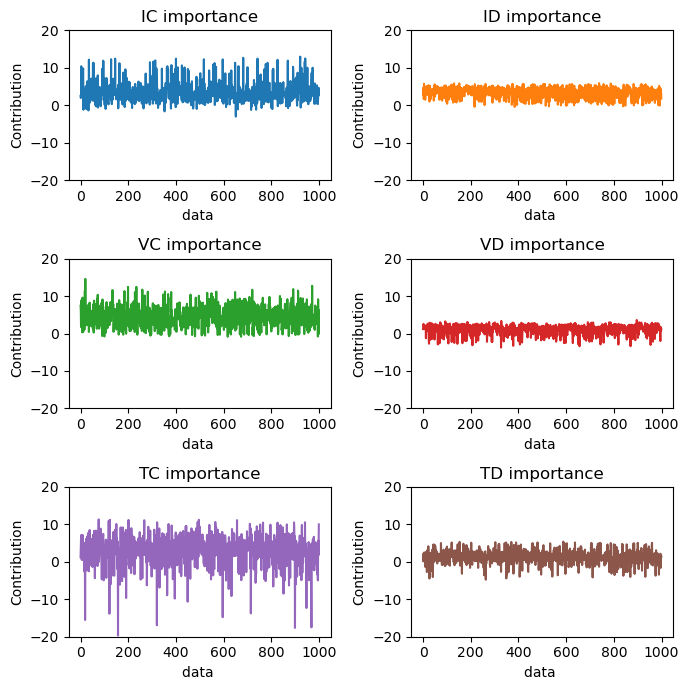

In [27]:
t = np.arange(-20, 20, 4)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
axs[0, 0].set_title("IC importance")
axs[0, 0].plot(values[0], color='C0')
axs[0, 0].set_xlabel("data ")
axs[0, 0].set_ylabel("Contribution")
axs[0, 0].set_ylim([-20, 20])


axs[0, 1].set_title("ID importance")
axs[0, 1].plot(values[1], color='C1')
axs[0, 1].set_xlabel("data ")
axs[0, 1].set_ylabel("Contribution")
axs[0, 1].set_ylim([-20, 20])

axs[1, 0].set_title("VC importance")
axs[1, 0].plot(values[2], color='C2')
axs[1, 0].set_xlabel("data ")
axs[1, 0].set_ylabel("Contribution")
axs[1, 0].set_ylim([-20, 20])

axs[1, 1].set_title("VD importance")
axs[1, 1].plot(values[3], color='C3')
axs[1, 1].set_xlabel("data ")
axs[1, 1].set_ylabel("Contribution")
axs[1, 1].set_ylim([-20, 20])

axs[2, 0].set_title("TC importance")
axs[2, 0].plot(values[4], color='C4')
axs[2, 0].set_xlabel("data ")
axs[2, 0].set_ylabel("Contribution")
axs[2, 0].set_ylim([-20, 20])

axs[2, 1].set_title("TD importance")
axs[2, 1].plot(values[5], color='C5')
axs[2, 1].set_xlabel("data ")
axs[2, 1].set_ylabel("Contribution")
axs[2, 1].set_ylim([-20, 20])
fig.tight_layout()
fig.savefig("feimlstm.pdf", format="pdf", dpi=1200)

In [28]:
t=np.argsort((shap_values))[::-1][:6]
shap_values.sort(reverse=True)

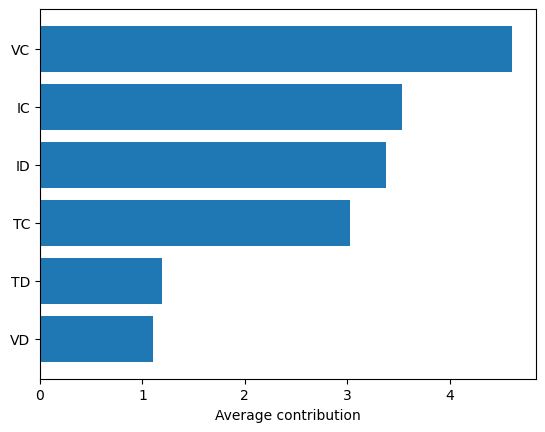

In [29]:
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = feature_names
y_pos = np.arange(6)
performance = shap_values

ax.barh(y_pos,performance, align='center')
ax.set_yticks(y_pos, labels=(feature_names[t[0]],feature_names[t[1]],feature_names[t[2]],feature_names[t[3]],feature_names[t[4]],feature_names[t[5]]))
ax.invert_yaxis()  
ax.set_xlabel('Average contribution')
fig.savefig("summarylstm.pdf", format="pdf", dpi=1200)
plt.show()

In [30]:
def calculate_shap_values2(model,X):
    M=1000
    ic=[]
    id=[]
    vc=[]
    vd=[]
    tc=[]
    td=[]
    sg=[ic,id,vc,vd,tc,td]
    ss=[ic.copy(),id.copy(),vc.copy(),vd.copy(),tc.copy(),td.copy()]
    for i in range(M):
        for j in range(6):
            z_index=random.sample(range(len(X)),1)[0]
            z = np.reshape(X[z_index-1:z_index],(10,6,848))
            x_jg=z.copy()
            x_js=z.copy()
            for k in range(10):
                x_jg[k][j]=z[k][j]+0.5
                x_js[k][j]=z[k][j]-0.5
            y_with_j=model.predict(np.reshape(z,(1,10,6,848)),verbose = 0)
            y_without_gj=model.predict(np.reshape(x_jg,(1,10,6,848)),verbose = 0)
            y_without_sj=model.predict(np.reshape(x_js,(1,10,6,848)),verbose = 0)
            sg[j].append(np.average(y_with_j-y_without_gj))
            ss[j].append(np.average(y_with_j-y_without_sj))
    
    return ss,sg

In [31]:
values1,values2=calculate_shap_values2(model,X2)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


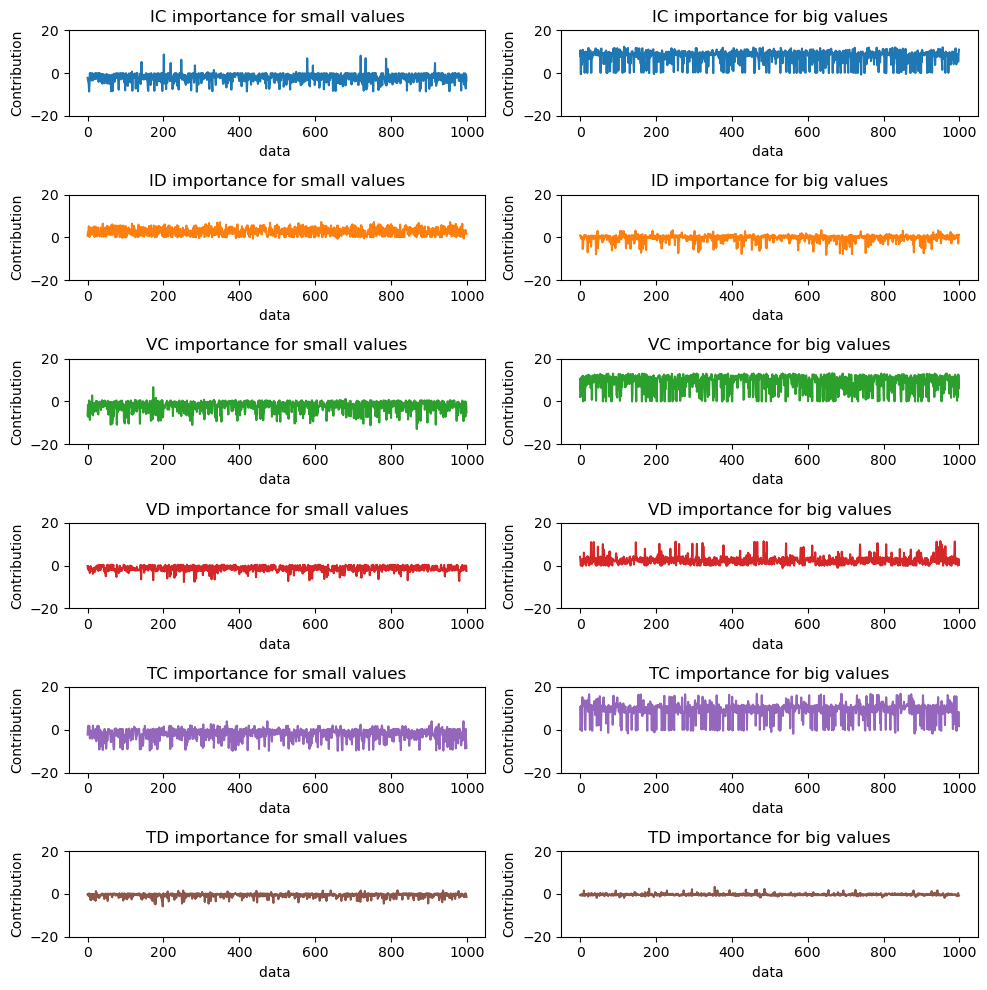

In [18]:
t = np.arange(-20, 20, 4)
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(10, 10))
axs[0, 0].set_title("IC importance for small values")
axs[0, 0].plot(values1[0], color='C0')
axs[0, 0].set_xlabel("data ")
axs[0, 0].set_ylabel("Contribution")
axs[0, 0].set_ylim([-20, 20])

axs[0, 1].set_title("IC importance for big values")
axs[0, 1].plot(values2[0], color='C0')
axs[0, 1].set_xlabel("data ")
axs[0, 1].set_ylabel("Contribution")
axs[0, 1].set_ylim([-20, 20])


axs[1, 0].set_title("ID importance for small values")
axs[1, 0].plot(values1[1], color='C1')
axs[1, 0].set_xlabel("data ")
axs[1, 0].set_ylabel("Contribution")
axs[1, 0].set_ylim([-20, 20])

axs[1, 1].set_title("ID importance for big values")
axs[1, 1].plot(values2[1], color='C1')
axs[1, 1].set_xlabel("data ")
axs[1, 1].set_ylabel("Contribution")
axs[1, 1].set_ylim([-20, 20])

axs[2, 0].set_title("VC importance for small values")
axs[2, 0].plot(values1[2], color='C2')
axs[2, 0].set_xlabel("data ")
axs[2, 0].set_ylabel("Contribution")
axs[2, 0].set_ylim([-20, 20])

axs[2, 1].set_title("VC importance for big values")
axs[2, 1].plot(values2[2], color='C2')
axs[2, 1].set_xlabel("data ")
axs[2, 1].set_ylabel("Contribution")
axs[2, 1].set_ylim([-20, 20])

axs[3, 0].set_title("VD importance for small values")
axs[3, 0].plot(values1[3], color='C3')
axs[3, 0].set_xlabel("data ")
axs[3, 0].set_ylabel("Contribution")
axs[3, 0].set_ylim([-20, 20])

axs[3, 1].set_title("VD importance for big values")
axs[3, 1].plot(values2[3], color='C3')
axs[3, 1].set_xlabel("data ")
axs[3, 1].set_ylabel("Contribution")
axs[3, 1].set_ylim([-20, 20])

axs[4, 0].set_title("TC importance for small values")
axs[4, 0].plot(values1[4], color='C4')
axs[4, 0].set_xlabel("data ")
axs[4, 0].set_ylabel("Contribution")
axs[4, 0].set_ylim([-20, 20])

axs[4, 1].set_title("TC importance for big values")
axs[4, 1].plot(values2[4], color='C4')
axs[4, 1].set_xlabel("data ")
axs[4, 1].set_ylabel("Contribution")
axs[4, 1].set_ylim([-20, 20])

axs[5, 0].set_title("TD importance for small values")
axs[5, 0].plot(values1[5], color='C5')
axs[5, 0].set_xlabel("data ")
axs[5, 0].set_ylabel("Contribution")
axs[5, 0].set_ylim([-20, 20])

axs[5, 1].set_title("TD importance for big values")
axs[5, 1].plot(values2[5], color='C5')
axs[5, 1].set_xlabel("data ")
axs[5, 1].set_ylabel("Contribution")
axs[5, 1].set_ylim([-20, 20])





fig.tight_layout()

In [32]:
avg=[]
for i in range(6):
    avg.append((np.average(values1[i]),np.average(values2[i])))

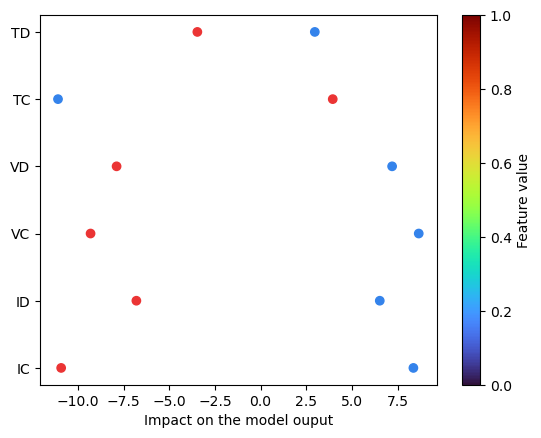

In [33]:
fig, ax = plt.subplots()
colormap = plt.cm.get_cmap('turbo')
sc = ax.scatter(np.array(avg),["IC","IC","ID","ID","VC","VC","VD","VD","TC","TC","TD","TD"], c=['#3483eb', "#eb3434",
 '#3483eb', "#eb3434",
'#3483eb', "#eb3434",
'#3483eb', "#eb3434",
'#3483eb', "#eb3434",
'#3483eb', "#eb3434",])
ax.set_xlabel('Impact on the model ouput', loc='center')
sm = plt.cm.ScalarMappable(cmap=colormap)
cbar = fig.colorbar(sm)
cbar.set_label("Feature value", loc='center')
fig.savefig("fimpactlstm.pdf", format="pdf", dpi=1200)
plt.show()

In [10]:
def calculate_shap_values3(model,X,f):
    from matplotlib.collections import LineCollection
    from matplotlib.colors import ListedColormap, BoundaryNorm
    s=[]
    y_with_j=model.predict(np.reshape(X,(1,10,6,848)),verbose = 0)
    for i in range(10):
            for k in range(848):
                x_j=X.copy()
                x_j[i][f][k]=np.random.rand()
                y_without_j=model.predict(np.reshape(x_j,(1,10,6,848)),verbose = 0)
                s.append(np.average(y_with_j-y_without_j))
    
    return s

In [72]:
x_all=test[0].drop(["SOH","charge_policy"],axis=1)
y_all=test[0]["SOH"]
x_all=x_all[0:10]
y_all=x_all[0:10]
x_normalize=normalization(x_all.copy(),minmax)
x_all=prepare(x_all)

In [73]:
def trim(array):
    last_non_zero_index = len(array) - 1
    while array[last_non_zero_index] == 0:
        last_non_zero_index -= 1

    # Remove the padding by slicing the array
    trimmed_array = array[:last_non_zero_index + 1]
    return trimmed_array
    
    
    

In [74]:
val=calculate_shap_values3(model,x_normalize,5)

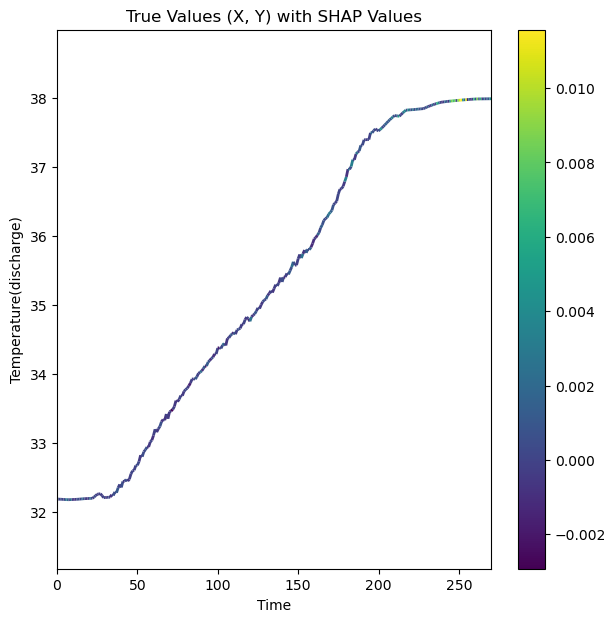

In [44]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
f=2
name='volatge(charge)'
values=trim(x_all[0][f])
shap_values=val[0:len(values)]
x =np.array(range(len(values)))
y = np.array(values) 
dydx = np.array(shap_values)  

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7, 7))

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)
axs.set_xlim(x.min(), x.max())
axs.set_ylim(y.min()-1,y.max()+1)
plt.xlabel("Time")
plt.ylabel(name)
plt.title('True Values (X, Y) with SHAP Values')
plt.savefig(name+'.pdf')
plt.show()


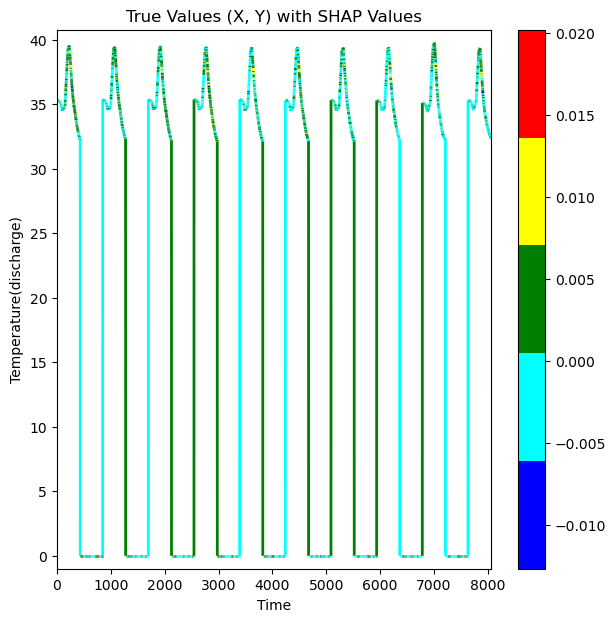

In [75]:
colors =  ['blue', 'cyan', 'green', 'yellow', 'red']
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
name='Temperature(discharge)'
l=[]
f=4
for i in range(10):
    l.append(x_all[i][f])
l=np.array(l)
l=np.reshape(l,(8480,))
values=trim(l)
shap_values=val
x =np.array(range(len(values)))
y = np.array(values) 
dydx = np.array(shap_values)  

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7, 7))

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap=ListedColormap(colors), norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)
axs.set_xlim(x.min(), x.max())
axs.set_ylim(y.min()-1,y.max()+1)
plt.xlabel("Time")
plt.ylabel(name)
plt.title('True Values (X, Y) with SHAP Values')
plt.savefig(name+'.pdf')
plt.show()